In [1]:
import os
import h5py
import pytest
import numpy as np
import glob
import shutil
import tempfile

with open('../dask_io/config.json') as json_conffile:
    import json
    data = json.load(json_conffile)
    import sys
    sys.path.insert(0, data['dask_path'])
    sys.path.insert(0, '../')

import dask
import dask.array as da

from dask_io.optimizer.cases.case_config import Split, Merge
from dask_io.optimizer.cases.case_creation import get_arr_chunks
from dask_io.optimizer.configure import enable_clustering, disable_clustering
from dask_io.optimizer.utils.utils import ONE_GIG, CHUNK_SHAPES_EXP1
from dask_io.optimizer.utils.get_arrays import get_dask_array_from_hdf5
from dask_io.optimizer.utils.array_utils import inspect_h5py_file
from dask_io.optimizer.utils.get_arrays import create_random_dask_array, save_to_hdf5

# Config

In [2]:
# for split
buffer_size = 4 * ONE_GIG

# reconstructed array
inputfilepath = './small_array_nochunk.hdf5'
inputfileshape = (120, 120,1)

# for resplit
O = (40,40,1)
I = (30,30,1)

# Create reconstructed array

In [3]:
# from tests/utils
def create_test_array_nochunk(file_path, shape):
    if not os.path.isfile(file_path):
        arr = create_random_dask_array(shape, distrib='normal', dtype=np.float16)
        save_to_hdf5(arr, file_path, physik_cs=None, key='/data', compression=None)

In [4]:
# create and change to tmp dir
old_cwd = os.getcwd()
tmpdir = tempfile.TemporaryDirectory()
os.chdir(tmpdir.name)

# create array
create_test_array_nochunk(inputfilepath, inputfileshape)

Creating a new random array
- shape: (120, 120, 1)
- distrib: normal
- dtype: <class 'numpy.float16'>
Saving a dask array at ./small_array_nochunk.hdf5:
- physik_cs: None
- key: /data
- compression: None
INSIDE CUSTOM DASK
Array successfully saved.

Inspecting created file...
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (120, 120, 1)
	 - Size: 14400
	 - Dtype: float16


# Split to create input files

In [5]:
def split():
    filetosplitpath = inputfilepath
    splitfilesshape = I
    case = Split(filetosplitpath, splitfilesshape)
    case.split_hdf5_multiple('./', nb_blocks=None) # split all blocks into different files
    arr = case.get()
    arr.compute()
    case.clean()

In [6]:
split()

Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (120, 120, 1)
	 - Size: 14400
	 - Dtype: float16
INSIDE CUSTOM DASK


# Get reconstructed array

In [7]:
case = Merge('./reconstructed.hdf5') # dont care about the name of outfile bec we retrieve without actually merging
case.merge_hdf5_multiple('./', store=False)
reconstructed_array = case.get()

Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (30, 30, 1)
	 - Size: 900
	 - Dtype: float32
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (30, 30, 1)
	 - Size: 900
	 - Dtype: float32
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (30, 30, 1)
	 - Size: 900
	 - Dtype: float32
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (30, 30, 1)
	 - Size: 900
	 - Dtype: float32
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (30, 30, 1)
	 - Size: 900
	 - Dtype: float32
Inspecting h5py file...
	Found object /data a

In [8]:
reconstructed_array

dask.array<concatenate, shape=(120, 120, 1), dtype=float32, chunksize=(30, 30, 1)>

In [9]:
reconstructed_array = reconstructed_array.rechunk(60,60,1)

In [10]:
reconstructed_array

dask.array<rechunk-merge, shape=(120, 120, 1), dtype=float32, chunksize=(60, 60, 1)>

# Define resplit store scheme

Case is as follows:
- 2D case
- let us say we can store f1 but not (f2 and f3)

## Defining a dictionary to slice reconstructed array into volumes to be store

In [11]:
# first is j, second is k, according to F ordering
d_arrays = {
    0: [(slice(0, 40, None),slice(0, 40, None),  slice(None, None, None))],
    1: [(slice(40, 80, None),slice(0, 40, None),  slice(None, None, None))],
    2: [(slice(80, 120, None),slice(0, 40, None),  slice(None, None, None))],
    3: [(slice(0, 40, None),slice(40, 60, None),  slice(None, None, None)),
        (slice(0, 40, None),slice(60, 80, None),  slice(None, None, None))],
    4: [(slice(40, 60, None),slice(40, 60, None),  slice(None, None, None)),
       (slice(60, 80, None),slice(40, 60, None),  slice(None, None, None)),
       (slice(40, 80, None),slice(60, 80, None),  slice(None, None, None))],
    5: [(slice(80, 120, None),slice(40, 60, None),  slice(None, None, None)),
        (slice(80, 120, None),slice(60, 80, None),  slice(None, None, None))],
    6: [
        ( slice(0, 40, None),slice(80, 120, None), slice(None, None, None))
    ],
    7: [
        (slice(40, 60, None),slice(80, 120, None),  slice(None, None, None)),
        (slice(60, 80, None),slice(80, 120, None),  slice(None, None, None))
    ],
    8: [(slice(80, 120, None),slice(80, 120, None),  slice(None, None, None))]
}

## Defining a dictionary to associate volumes to regions in outfile

In [12]:
d_regions = {
    0: [
        (slice(0, 40, None),slice(0, 40, None),  slice(None, None, None))
    ],
    1:[
        (slice(0, 40, None),slice(0, 40, None),  slice(None, None, None))
    ],
    2: [
        (slice(0, 40, None),slice(0, 40, None),  slice(None, None, None))
    ],
    3: [
        (slice(0, 40, None),slice(0, 20, None),  slice(None, None, None)),
        (slice(0, 40, None),slice(20, 40, None),  slice(None, None, None))
    ],
    4: [
        (slice(0, 20, None),slice(0, 20, None),  slice(None, None, None)),
        (slice(20, 40, None),slice(0, 20, None),    slice(None, None, None)),
        (slice(0, 40, None),slice(20, 40, None),  slice(None, None, None))
    ],
    5: [
        (slice(0, 40, None),slice(0, 20, None),  slice(None, None, None)),
        (slice(0, 40, None),slice(20, 40, None),  slice(None, None, None))
    ],
    6: [
        (slice(0, 40, None),slice(0, 40, None),  slice(None, None, None))
    ],
    7: [
        (slice(0, 20, None),slice(0, 40, None),  slice(None, None, None)),
        ( slice(20, 40, None),slice(0, 40, None), slice(None, None, None))
    ],
    8: [
        (slice(0, 40, None), slice(0, 40, None), slice(None, None, None))
    ]
}

# Resplitting

- sources = list()
- targets = list()
- regions = list()
- for each output file 
    - sliceslistoflist = get slices from d
    - create a file
    - create a dataset inside this file
    - for slicetuple in sliceslistoflist
        - add to source
            - create array from slicestuple
            - add this array to source
        - add to target
            - add dataset in target
        - add to region 
            - add slicestuple in regions

In [13]:
out_files = list() # to keep outfiles open during processing

sources = list()
targets = list()
regions = list()
for outfile_index in range(9):
    sliceslistoflist = d_arrays[outfile_index]
    
    # create file
    out_file = h5py.File('./' + str(outfile_index) + '.hdf5', 'w')
    out_files.append(out_file)
    
    # create dset
    dset = out_file.create_dataset('/data', shape=O)
    
    for i, st in enumerate(sliceslistoflist):
        tmp_array = reconstructed_array[st[0], st[1]]
        reg = d_regions[outfile_index][i]
        tmp_array = tmp_array.rechunk(tmp_array.shape)
        
        sources.append(tmp_array)
        targets.append(dset)
        regions.append(reg)

In [14]:
task = da.store(sources, targets, regions=regions, compute=False)

INSIDE CUSTOM DASK


In [15]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with dask.config.set(scheduler='single-threaded'):
        task.compute()
    visualize([prof, rprof, cprof])

In [16]:
!ls

0_0_0.hdf5  1_1_0.hdf5	2_2_0.hdf5  3_3_0.hdf5	8.hdf5
0_1_0.hdf5  1_2_0.hdf5	2_3_0.hdf5  3.hdf5	profile.html
0_2_0.hdf5  1_3_0.hdf5	2.hdf5	    4.hdf5	small_array_nochunk.hdf5
0_3_0.hdf5  1.hdf5	3_0_0.hdf5  5.hdf5
0.hdf5	    2_0_0.hdf5	3_1_0.hdf5  6.hdf5
1_0_0.hdf5  2_1_0.hdf5	3_2_0.hdf5  7.hdf5


In [17]:
outfiles = list()
for fpath in glob.glob("[0-9].hdf5"):  # remove split files from previous tests
    f = h5py.File(fpath, 'r')
    print(f'Filename: {fpath}')
    inspect_h5py_file(f)

Filename: 8.hdf5
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (40, 40, 1)
	 - Size: 1600
	 - Dtype: float32
Filename: 7.hdf5
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (40, 40, 1)
	 - Size: 1600
	 - Dtype: float32
Filename: 6.hdf5
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (40, 40, 1)
	 - Size: 1600
	 - Dtype: float32
Filename: 5.hdf5
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (40, 40, 1)
	 - Size: 1600
	 - Dtype: float32
Filename: 4.hdf5
Inspecting h5py file...
	Found object /data at key data
	 - Object type: dataset
	 - Physical chunks shape: None
	 - Compression: None
	 - Shape: (

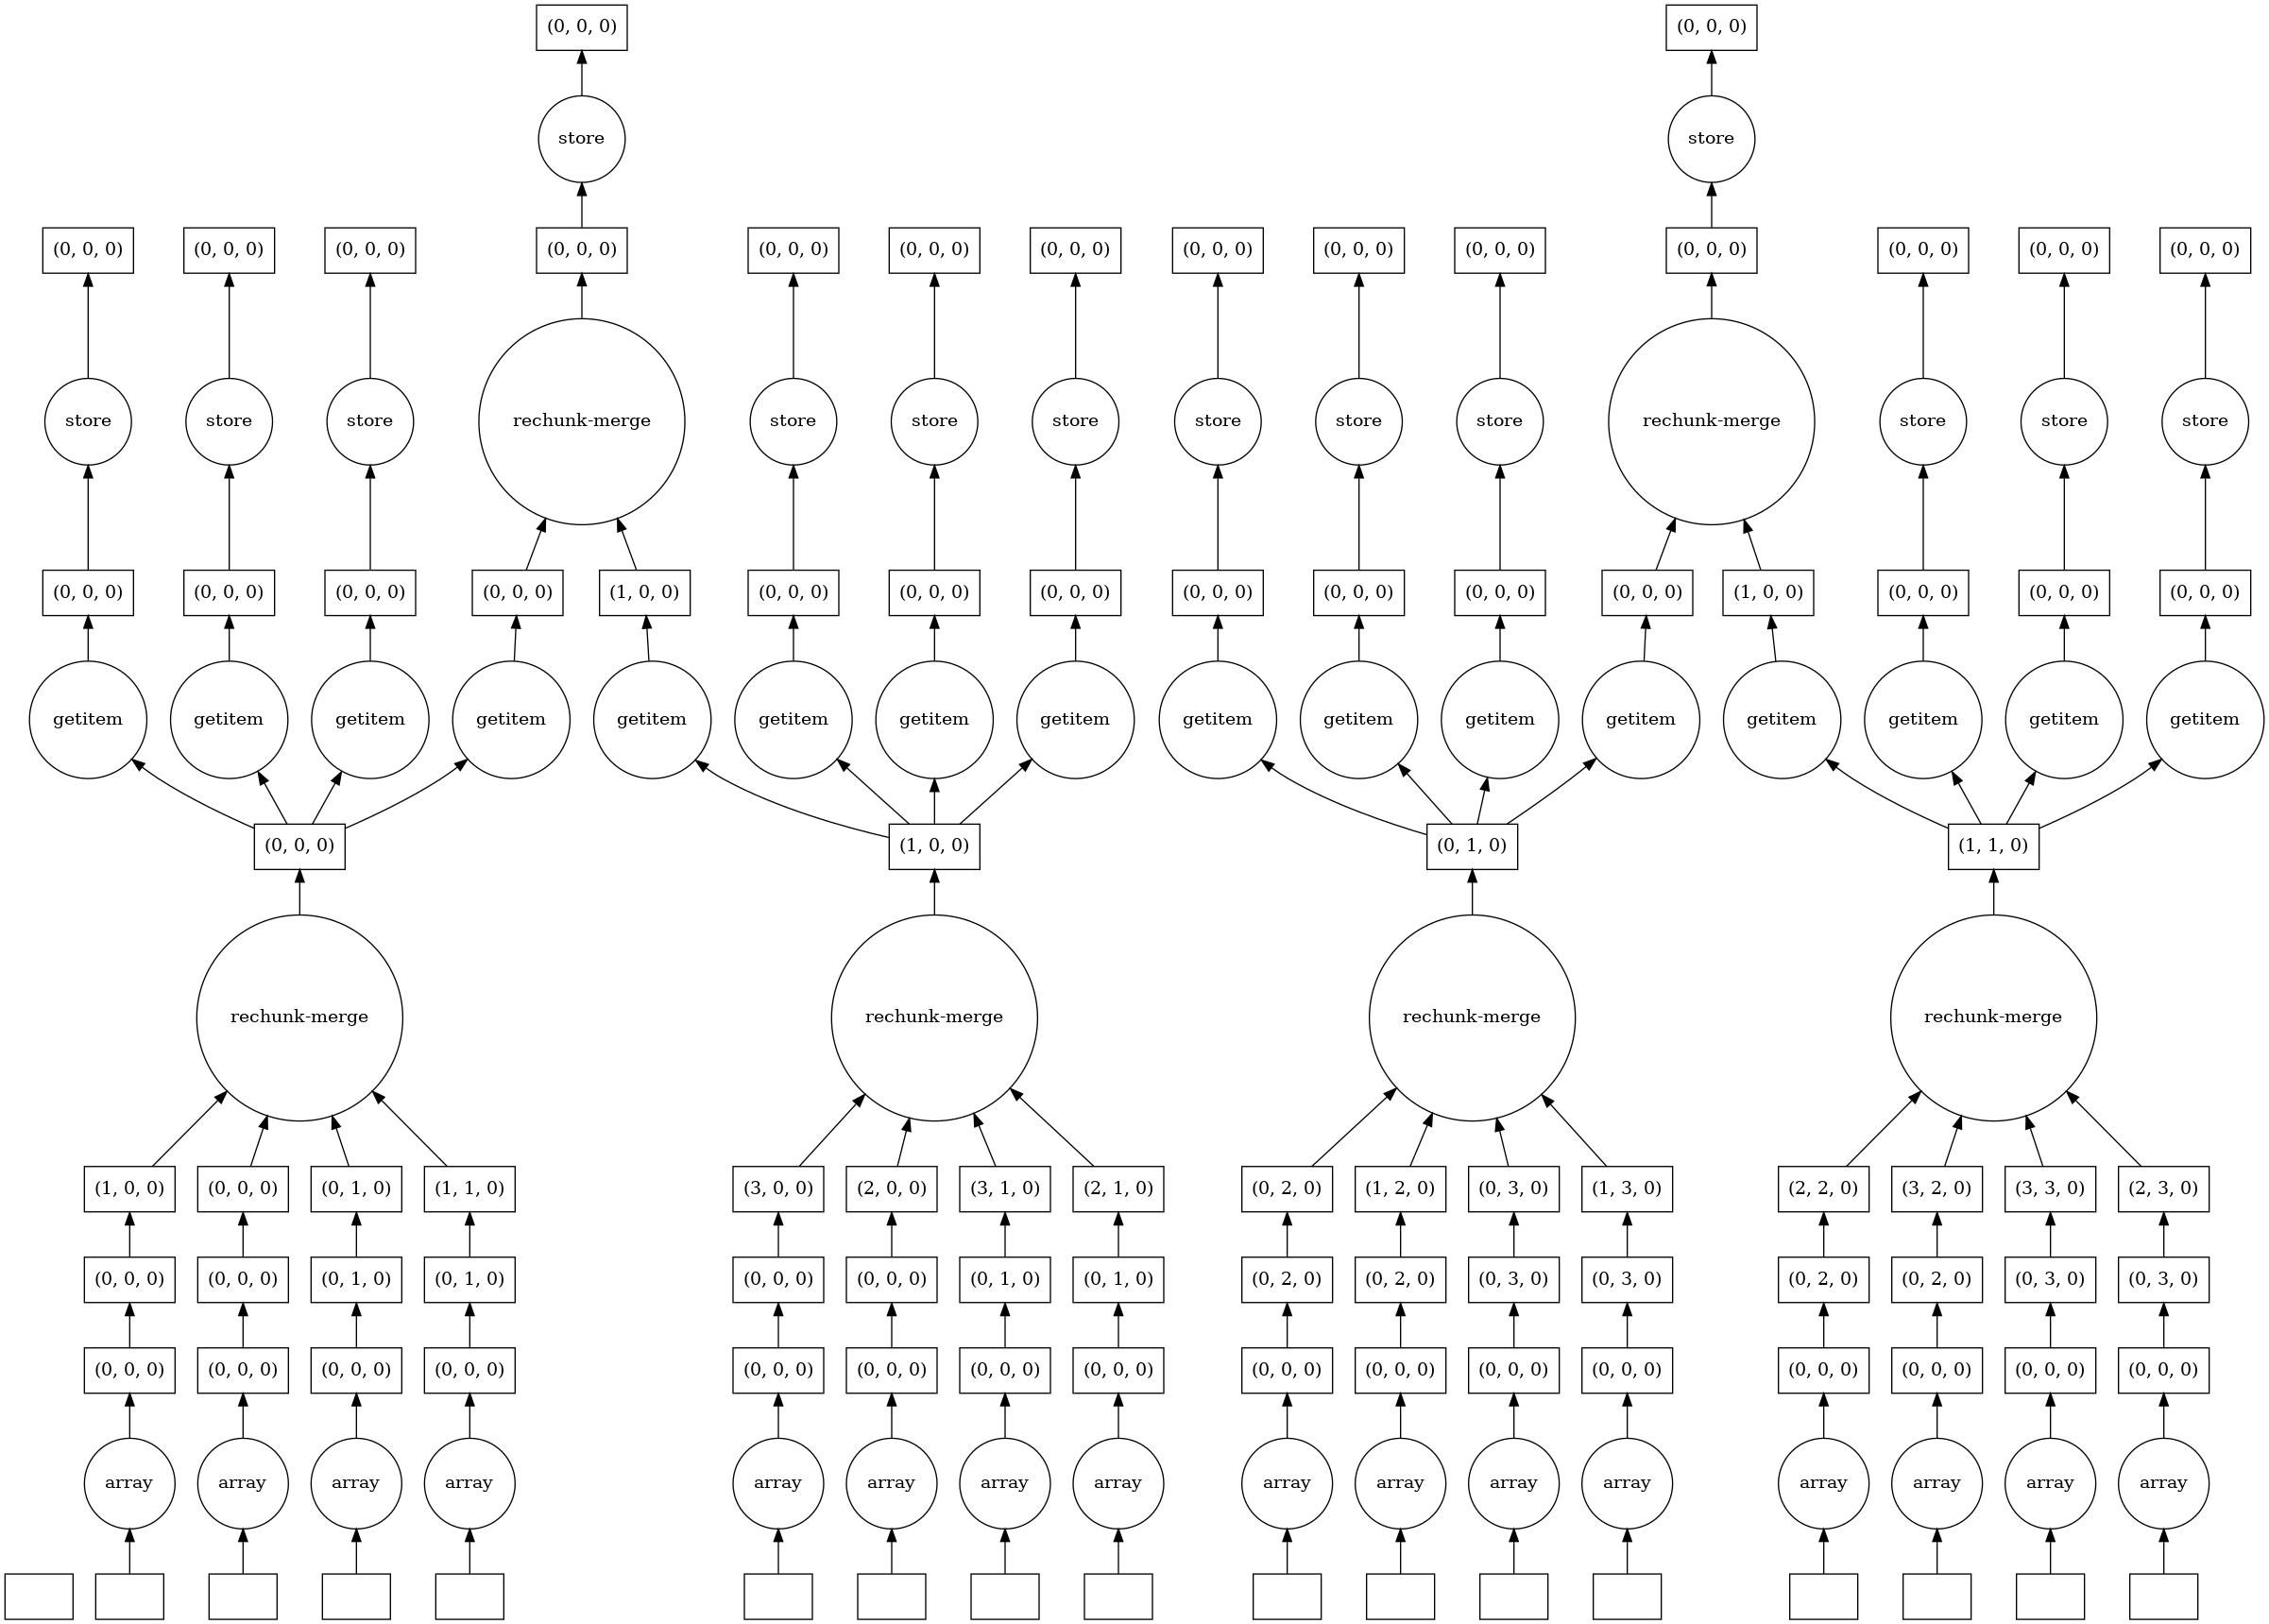

In [18]:
task.visualize(optimize_graph=False)

In [19]:
graph = task.dask.dicts

In [20]:
graph.keys()

dict_keys([140461540829616, 140461540443392, 140461540755888, 140461540756128, 140461540757408, 140461540756608, 140461540592368, 140461540436240, 140461540436320, 140461540436080, 140461540435520, 140461540435440, 140461540443312, 140461540829216, 140461540829536, 'getitem-c94532ae010993933f1b423ffb1fdb65', 'rechunk-merge-8f86b93f444b33c1f5d062b28a2d0e6c', 'concatenate-d6567180bdd31191d529de25fbf1d331', 'concatenate-378461601bd397addca99f556b851d01', 'array-53d941357e340480b0e826806802f783', 'array-6e88dfc9b6cfad2e357c4de0ae01ae77', 'array-768576e26da6f7794bc3bad7a6a7cc14', 'array-6844c63458b517be82a6e3b8e0f7de60', 'concatenate-8f68db74e3ae69ea289b1551f035b207', 'array-fe4610deff728823d4f4b48bc976dd7b', 'array-1511beefc1dbdf1b2664f4fc81879dba', 'array-9f4a07e3bb6c43c2c10c7438713718e6', 'array-d5ec12f8441ca0518131711410ecdc99', 'concatenate-c506cae4faddbcf5d1929e8fb7c844a8', 'array-3d7416e41cd5fc0fa5ed0a1dc64dc421', 'array-61c0cc4664866de6b9d64d276b1f3579', 'array-d83f98b6d7cd3c6852bff